<a href="https://colab.research.google.com/github/Ron-Wu/deep-learning-test/blob/main/03face_identification_FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# VGGFAce: https://github.com/rcmalli/keras-vggface
# !pip install keras_vggface

In [ ]:
# # downlaod facenet model
# !gdown --id 1n1HPr_4Zb36itO-Oxv7_NpTlYSMsX2Gw

In [2]:
FOLDER_PATH = '/content/drive/MyDrive/勞動部/03-CNN-Applications/Face_recognition'
# FOLDER_PATH = '.'

In [3]:
import pickle

import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import os


# import keras_vggface
# from keras_vggface import VGGFace
# from keras_vggface.utils import preprocess_input

In [4]:
names = ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
cls_map = {'ben_afflek': 0,
            'elton_john': 1,
            'jerry_seinfeld': 2,
            'madonna': 3,
            'mindy_kaling': 4}

In [5]:
# model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
model = load_model(os.path.join(FOLDER_PATH, 'facenet.h5'))
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [6]:
# load from pickle file
with open(os.path.join(FOLDER_PATH, 'X_train.pickle'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(FOLDER_PATH, 'y_train.pickle'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(FOLDER_PATH, 'X_val.pickle'), 'rb') as file:
    X_val = pickle.load(file)
with open(os.path.join(FOLDER_PATH, 'y_val.pickle'), 'rb') as file:
    y_val = pickle.load(file)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((93, 160, 160, 3), (93, 1), (25, 160, 160, 3), (25, 1))

### Preprocess images

In [7]:
def preprocess(imgs):
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs
        
X_train = preprocess(X_train)
X_val = preprocess(X_val)

In [8]:
def create_pairs(x, face_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(face_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # positive pairs
            z1, z2 = face_indices[d][i], face_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # negative pairs
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = face_indices[d][i], face_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
face_indices = [np.where(y_train == i)[0] for i in range(len(names))]
train_pairs, train_y = create_pairs(X_train, face_indices, num_classes=len(names))

face_indices = [np.where(y_val == i)[0] for i in range(len(names))]
val_pairs, val_y = create_pairs(X_val, face_indices, num_classes=len(names))

In [9]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

In [10]:
all_pairs = np.concatenate((train_pairs, val_pairs))
all_labels = np.concatenate((train_y, val_y))

In [11]:
positive_pairs = all_pairs[all_labels == 1]
negative_pairs = all_pairs[all_labels == 0]

In [12]:
positive_pairs.shape, negative_pairs.shape

((85, 2, 160, 160, 3), (85, 2, 160, 160, 3))

In [13]:
def get_distance(pairs):
    embedding1 = model.predict([pairs[:, 0]])
    embedding2 = model.predict([pairs[:, 1]])
    distances = np.zeros((embedding1.shape[0]))
    for i in range(embedding1.shape[0]):
        emb1, emb2 = embedding1[i], embedding2[i]
        distances[i] = euclidean_distance(emb1, emb2)
    return distances

positive_distances = get_distance(positive_pairs)
negative_distances = get_distance(negative_pairs)

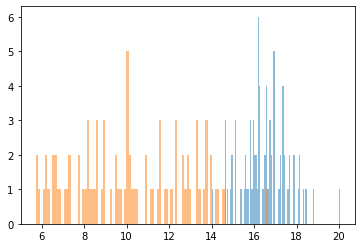

In [14]:
plt.hist(negative_distances[:], bins=100, alpha=0.5)
plt.hist(positive_distances[:], bins=100, alpha=0.5)
plt.show()